In [ ]:
def file_ext(file, queries):
    file_list = []
    with open(file) as fileobj:
        content = fileobj.read()
        lines = content.split('\n\n')[1:-1]

    for line in lines:
        sub = line.split('\n')[:2]
        query = sub[0].split('\t')[1].split(' ')[0][1:]
        if query in set(queries):
            match = sub[1].split('\t')[2].split(' ')[0][1:]
            file_list.append(str(query) + ' ' + str(match))
    
    return set(file_list)

In [ ]:
def f_ext(file):
    with open(file, 'r') as f:
        obj = json.load(f)
    main_l = []
    for q in obj:
        que = q['Query']['ID'].split(' ')[0][1:]
        t1 = q['Query']['Matches'][0]['ID'].split(' ')[0][1:]
        conf = q['Query']['Confidence']
        score = q['Query']['Matches'][0]['Score']
        main_l.append({'Query' : que, 'T1' : t1, 'Score' : score,'Conf' : conf})
    return pd.DataFrame(main_l)


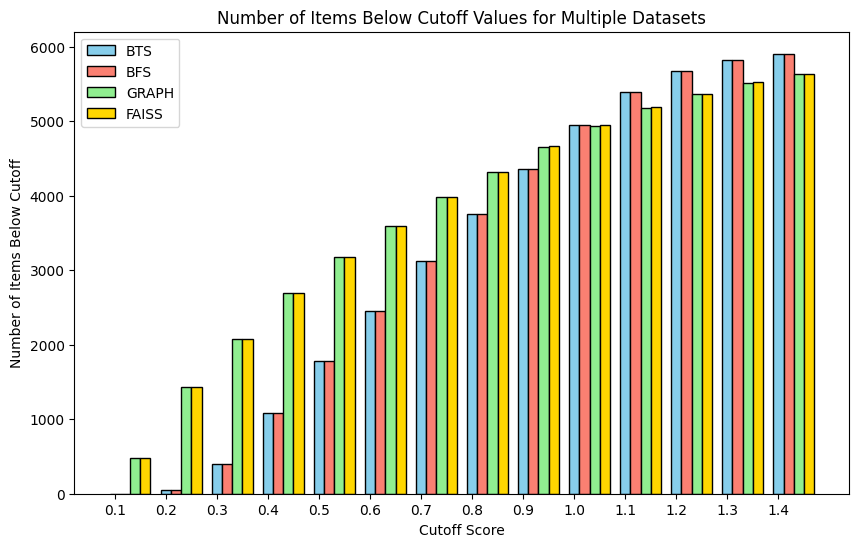

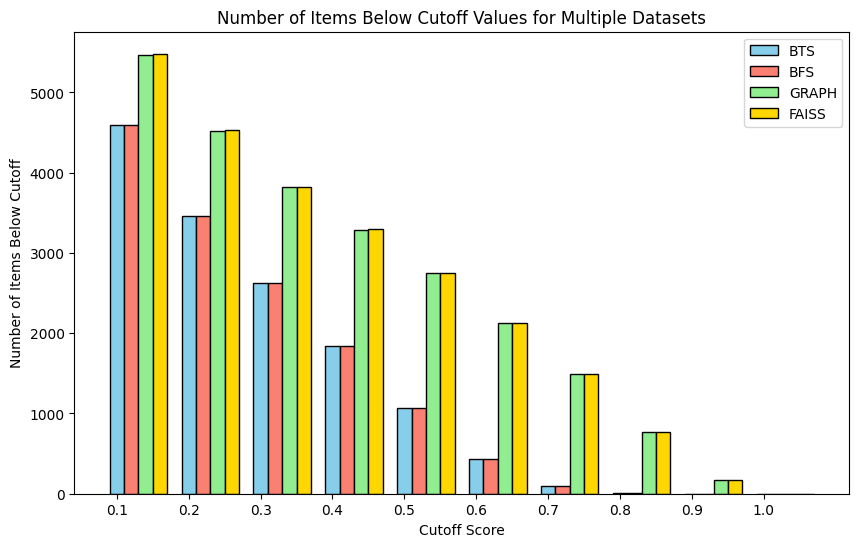

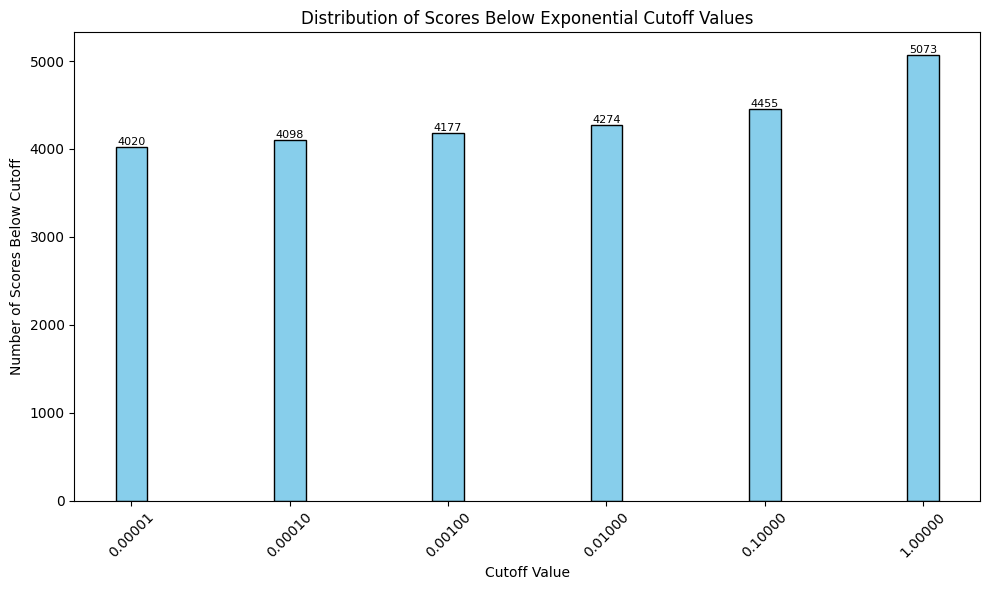

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def f_ext(file):
    with open(file, 'r') as f:
        obj = json.load(f)
    main_l = []
    for q in obj:
        que = q['Query']['ID'].split(' ')[0][1:]
        t1 = q['Query']['Matches'][0]['ID'].split(' ')[0][1:]
        conf = q['Query']['Confidence']
        score = q['Query']['Matches'][0]['Score']
        main_l.append({'Query' : que, 'T1' : t1, 'Score' : score,'Conf' : conf})
    return pd.DataFrame(main_l)


def plot_multiple_score_distributions(cutoff, conf_flag, *data_lists):
    # Define cutoff values from 0.1 to 1.5 with increments of 0.1
    cutoff_values = np.arange(0.1, cutoff, 0.1)
    labels = ['BTS', 'BFS', 'GRAPH', 'FAISS']
    
    
    # Colors for each dataset
    colors = ["skyblue", "salmon", "lightgreen", "gold"]
    
    # Plot histogram for each dataset
    plt.figure(figsize=(10, 6))
    for i, data in enumerate(data_lists):
        # Calculate the number of items below each cutoff for the current list
        if conf_flag:
            counts = [np.sum(np.array(data) >= cutoff) for cutoff in cutoff_values]
        else:
            counts = [np.sum(np.array(data) <= cutoff) for cutoff in cutoff_values]
        
        # Plot the histogram for this list
        plt.bar(cutoff_values + i * 0.02, counts, width=0.02, color=colors[i % len(colors)],
                edgecolor="black", align="center", label=labels[i])
        
    # Set plot labels and title
    plt.xlabel("Cutoff Score")
    plt.ylabel("Number of Items Below Cutoff")
    plt.title("Number of Items Below Cutoff Values for Multiple Datasets")
    plt.xticks(cutoff_values)
    plt.legend()
    plt.show()

def plot_exponential_cutoff_distribution(scores):
    # Define exponential cutoff values from 0.00001 to 1
    cutoff_values = np.logspace(-5, 0, num=6)

    # Calculate the number of items below each cutoff
    counts = [np.sum(np.array(scores) < cutoff) for cutoff in cutoff_values]

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(cutoff_values)), counts, width=0.2, color='skyblue', edgecolor='black')

    # Customize plot
    plt.xticks(range(len(cutoff_values)), [f"{val:.5f}" for val in cutoff_values], rotation=45)
    plt.xlabel("Cutoff Value")
    plt.ylabel("Number of Scores Below Cutoff")
    plt.title("Distribution of Scores Below Exponential Cutoff Values")

    # Annotate each bar with the count value
    for i, count in enumerate(counts):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


with open(" baker2fission.e1.txt") as fileobj:
    content = fileobj.read()
    lines = content.split('\n')

linewise = []
queries = []
for line in lines[:-1]:
    ph = line.split('\t')
    queries.append(ph[0])
    linewise.append({'Query' : ph[0], 'Ref' : ph[1], 'Score' : eval(ph[-2])})

df = pd.DataFrame(linewise)
set_dict = []
for query in set(queries):
    temp = df[df['Query'] == query].sort_values('Score')
    temp = temp.iloc[0][['Query', 'Ref', 'Score']].to_dict()
    set_dict.append(temp)

e_df = pd.DataFrame(set_dict)

faiss_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/faiss_top10.json"
graph_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/graph_top10.json"
bts_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/bts_top10.json"
bfs_json = "/Users/sakshmenon/Desktop/PLM/Data Visualizing/5 Way Venn Plots/bfs_top10.json"

faiss_df = f_ext(faiss_json)
graph_df = f_ext(graph_json)
bts_df = f_ext(bts_json)
bfs_df = f_ext(bfs_json)

plot_multiple_score_distributions(1.5, 0, bts_df['Score'], bfs_df['Score'], graph_df['Score'], faiss_df['Score'])
plot_multiple_score_distributions(1.1, 1, bts_df['Conf'], bfs_df['Conf'], graph_df['Conf'], faiss_df['Conf'])
plot_exponential_cutoff_distribution(e_df['Score'])

/var/folders/h3/pl4_4z116_dcntldrzwpn49w0000gn/T/ipykernel_56522/1213316800.py:130: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  raw_e_val.append(float(e_df[e_df['Query'] == q]['Score']))
/var/folders/h3/pl4_4z116_dcntldrzwpn49w0000gn/T/ipykernel_56522/1213316800.py:131: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  e_val.append(-math.log10(float(e_df[e_df['Query'] == q]['Score'])))


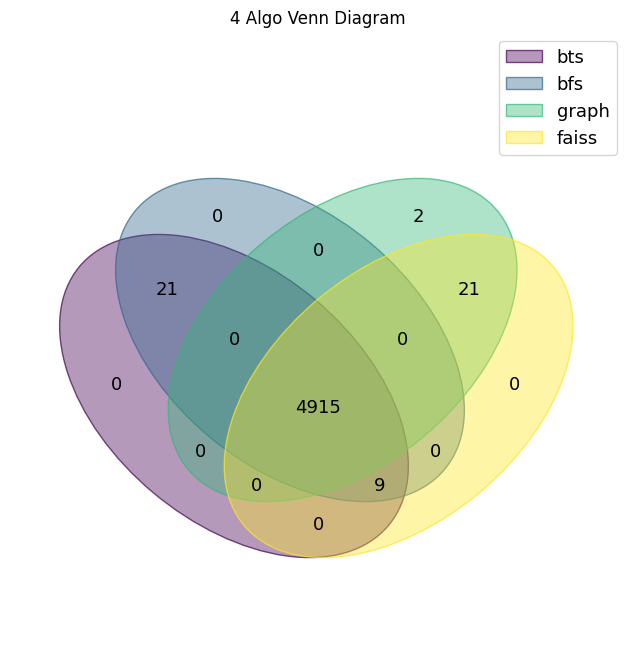

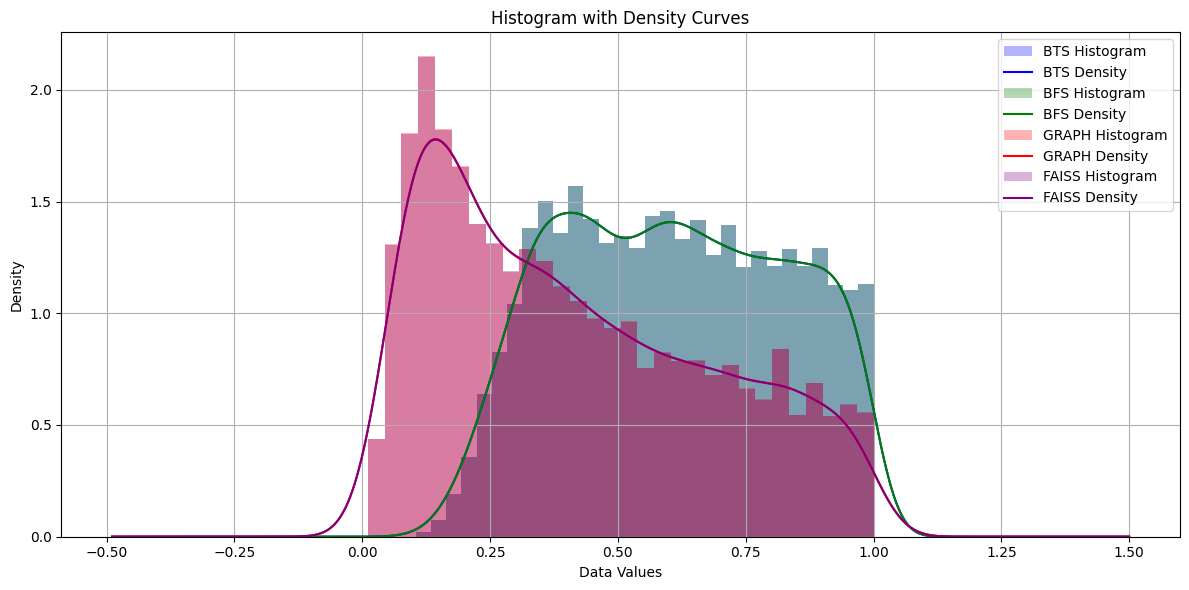

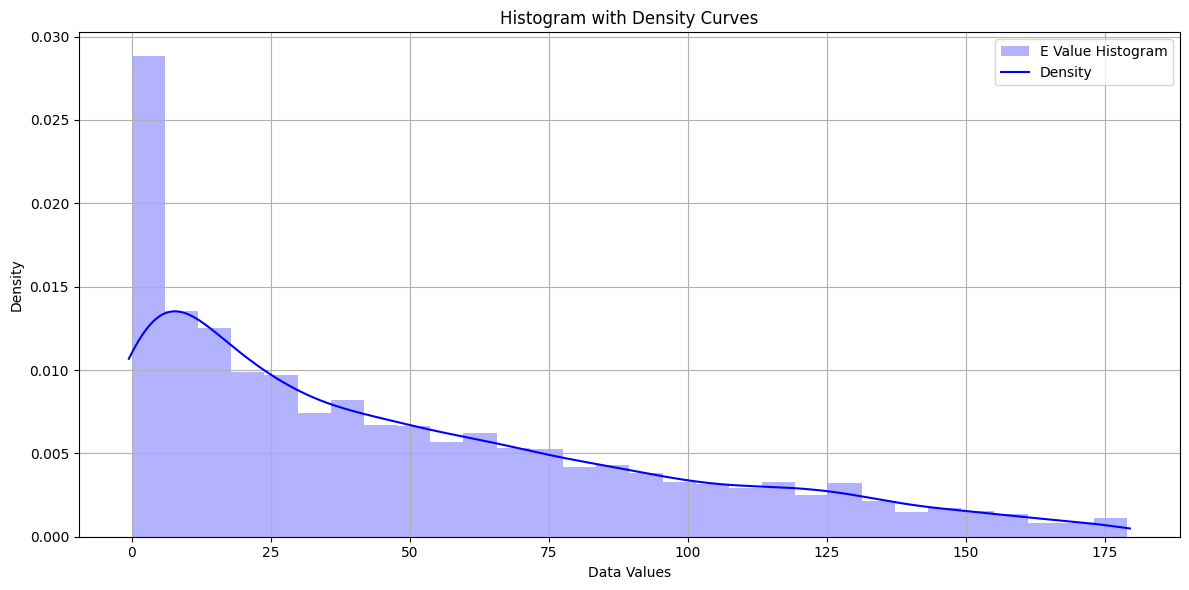

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from venn import venn
import pandas as pd
import json

def plot_density_curves(e_fl, *lists):
    # Prepare the data lists
    data_lists = lists
    colors = ['blue', 'green', 'red', 'purple']
    labels = ['BTS', 'BFS', 'GRAPH', 'FAISS']
    
    # Set up the plot
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    
    # Density Plot
    for i, data in enumerate(data_lists):
        density = gaussian_kde(data)
        x_vals = np.linspace(min(data) - 0.5, max(data) + 0.5, 1000)
        y_vals = density(x_vals)
        
        # Plot density curves
    
    # Histogram with Density Curves Overlay
    for i, data in enumerate(data_lists):
        # Plot histogram for each list with transparency
        if e_fl:
            axes.hist(data, bins=30, density=True, color=colors[i], alpha=0.3, label='E Value Histogram')

        else:
            axes.hist(data, bins=30, density=True, color=colors[i], alpha=0.3, label=f'{labels[i]} Histogram')
        
        # Overlay density curve on histogram
        density = gaussian_kde(data)
        y_vals = density(x_vals)
        if e_fl:
            axes.plot(x_vals, y_vals, color=colors[i], label='Density')

        else:
            axes.plot(x_vals, y_vals, color=colors[i], label=f'{labels[i]} Density')
    
    axes.set_title('Histogram with Density Curves')
    axes.set_xlabel('Data Values')
    axes.set_ylabel('Density')
    axes.legend()
    axes.grid(True)
    
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

def plot_venn_5_sets(sets_dict):
    venn(sets_dict)
    plt.title("4 Algo Venn Diagram")
    plt.show()

def f_ext(file):
    with open(file, 'r') as f:
        obj = json.load(f)
    main_l = []
    multi_match_list = {}
    for q in obj:
        que = q['Query']['ID'].split(' ')[0][1:]
        t1 = q['Query']['Matches'][0]['ID'].split(' ')[0][1:]
        t2 = q['Query']['Matches'][1]['ID'].split(' ')[0][1:]
        t3 = q['Query']['Matches'][2]['ID'].split(' ')[0][1:]
        conf = q['Query']['Confidence']
        score1 = q['Query']['Matches'][0]['Score']
        score2 = q['Query']['Matches'][1]['Score']
        score3 = q['Query']['Matches'][2]['Score']

        score_set = [score1, score2, score3]
        if score_set.count(score1)>1:
            temp = [t1,t2,t3][0:score_set.count(score1)]
            temp.sort()
            multi_match_list[que] = temp
        main_l.append({'Query' : que, 'T1' : t1, 'Score' : score1,'Conf' : conf})
    return pd.DataFrame(main_l), multi_match_list

with open("baker2fission.e1.txt") as fileobj: #file path here
    content = fileobj.read()
    lines = content.split('\n')

linewise = []
queries = []
for line in lines[:-1]:
    ph = line.split('\t')
    queries.append(ph[0])
    linewise.append({'Query' : ph[0], 'Ref' : ph[1], 'Score' : eval(ph[-2])})

df = pd.DataFrame(linewise)
set_dict = []
for query in set(queries):
    temp = df[df['Query'] == query].sort_values('Score')
    temp = temp.iloc[0][['Query', 'Ref', 'Score']].to_dict()
    set_dict.append(temp)

e_df = pd.DataFrame(set_dict)

faiss_json = "faiss_top10.json" #file path here
graph_json = "graph_top10.json" #file path here
bts_json = "bts_top10.json" #file path here
bfs_json = "bfs_top10.json" #file path here

faiss_df, multi_match_list_faiss = f_ext(faiss_json)
graph_df, multi_match_list_graph = f_ext(graph_json)
bts_df, multi_match_list_bts = f_ext(bts_json)
bfs_df, multi_match_list_bfs = f_ext(bfs_json)

bts_set = set([i['Query'] + i['T1'] for i in bts_df[bts_df['Score'] <= 1].iloc()])
bfs_set = set([i['Query'] + i['T1'] for i in bfs_df[bfs_df['Score'] <= 1].iloc()])
graph_set = set([i['Query'] + i['T1'] for i in graph_df[graph_df['Score'] <= 1].iloc()])
faiss_set = set([i['Query'] + i['T1'] for i in faiss_df[faiss_df['Score'] <= 1].iloc()])

plot_set = {
'bts': bts_set,
'bfs': bts_set,
'graph': graph_set,
'faiss': faiss_set,
}

import math
ref_set = set(bts_df['Query'][bts_df['Score'] <= 1].to_list() + bfs_df['Query'][bfs_df['Score'] <= 1].to_list() + graph_df['Query'][graph_df['Score'] <= 1].to_list() + faiss_df['Query'][faiss_df['Score'] <= 1].to_list())
e_val = []
raw_e_val = []
for q in ref_set:
    if q in e_df['Query'].to_list():
        try:
            raw_e_val.append(float(e_df[e_df['Query'] == q]['Score']))
            e_val.append(-math.log10(float(e_df[e_df['Query'] == q]['Score'])))
        except:
            pass

plot_venn_5_sets(plot_set)

plot_density_curves(0, bts_df[bts_df['Score'] <= 1]['Score'], bfs_df[bfs_df['Score'] <= 1]['Score'], graph_df[graph_df['Score'] <= 1]['Score'], faiss_df[faiss_df['Score'] <= 1]['Score'])

plot_density_curves(1, e_val)



Query without multiple similar top matches in at least one method detected:  NP_009676.1
Query without multiple similar top matches in at least one method detected:  NP_014165.1
Query without multiple similar top matches in at least one method detected:  NP_015405.1
Query without multiple similar top matches in at least one method detected:  NP_015440.1
Query without multiple similar top matches in at least one method detected:  NP_076906.1
Query without multiple similar top matches in at least one method detected:  NP_010104.1
Query without multiple similar top matches in at least one method detected:  NP_014055.1
Query without multiple similar top matches in at least one method detected:  NP_001257672.1
Query without multiple similar top matches in at least one method detected:  NP_878160.1
Query without multiple similar top matches in at least one method detected:  NP_014792.4
Query without multiple similar top matches in at least one method detected:  NP_013840.1
Query without mult

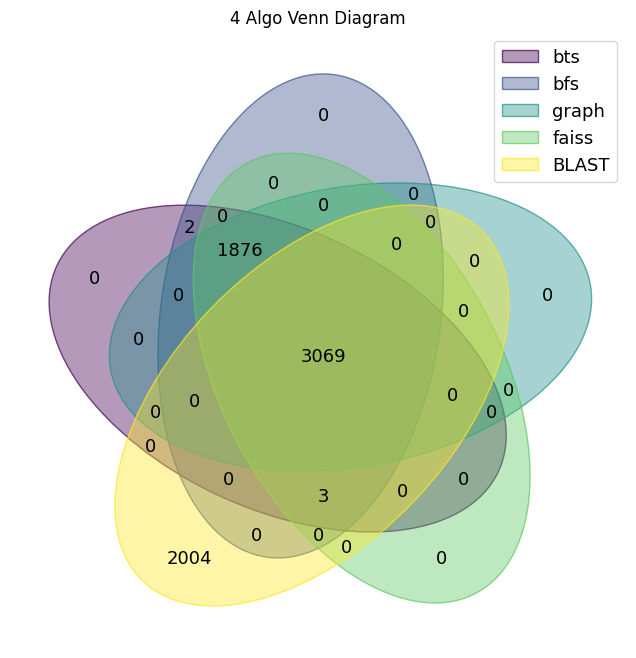

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from venn import venn
import pandas as pd
import json
import re

def plot_venn_5_sets(sets_dict):
    venn(sets_dict)
    plt.title("4 Algo Venn Diagram")
    plt.show()

def f_ext_30(filename):
    results = {}
    current_query = None

    # Define regex patterns for matching query lines and top match lines
    query_pattern = re.compile(r'^Query:\s+>(\S+)')
    match_pattern = re.compile(r'^Top\d+:\s+(\d\.\d{3})\s+>(\S+)')
    
    with open(filename, 'r') as file:
        for line in file:
            # Check for a query line
            query_match = query_pattern.search(line)
            if query_match:
                current_query = query_match.group(1)
                continue  # Move to the next line

            # Check for a top match line
            match_match = match_pattern.search(line)
            if match_match and current_query:
                score = float(match_match.group(1))
                match_id = match_match.group(2)
                if current_query in results.keys():
                    results[current_query].append({
                        'Match ID': match_id,
                        'Score': score })
                else:
                    results[current_query] = [{
                        'Match ID': match_id,
                        'Score': score}]
                    
                
        main_l = []
        multi_match_list = {}
        for q in results:
            que = q
            t1 = results[q][0]['Match ID']
            t2 = results[q][1]['Match ID']
            t3 = results[q][2]['Match ID']

            score1 = results[q][0]['Score']
            score2 = results[q][1]['Score']
            score3 = results[q][2]['Score']

            score_set = [score1, score2, score3]

            if score_set.count(score1)>1:
                temp = [t1,t2,t3][0:score_set.count(score1)]
                temp.sort()
                multi_match_list[que] = temp

            main_l.append({'Query' : que, 'T1' : t1, 'Score' : score1})

    return pd.DataFrame(main_l), multi_match_list

with open("baker2fission.e1.txt") as fileobj: #file path here
    content = fileobj.read()
    lines = content.split('\n')

linewise = []
queries = []
for line in lines[:-1]:
    ph = line.split('\t')
    queries.append(ph[0])
    linewise.append({'Query' : ph[0], 'Ref' : ph[1], 'Score' : eval(ph[-2])})

df = pd.DataFrame(linewise)
set_dict = []
for query in set(queries):
    temp = df[df['Query'] == query].sort_values('Score')
    temp = temp.iloc[0][['Query', 'Ref', 'Score']].to_dict()
    set_dict.append(temp)

e_df = pd.DataFrame(set_dict)

faiss_txt = "s_cerevisiae2s_pombe.faiss.k30.txt" #file path here
graph_txt = "s_cerevisiae2s_pombe.graph.k30.txt" #file path here
bts_txt = "s_cerevisiae2s_pombe.bts.k30.txt" #file path here
bfs_txt  = "s_cerevisiae2s_pombe.bfs.k30.txt" #file path here

faiss_df, multi_match_list_faiss = f_ext_30(faiss_txt)
graph_df, multi_match_list_graph = f_ext_30(graph_txt)
bts_df, multi_match_list_bts = f_ext_30(bts_txt)
bfs_df, multi_match_list_bfs = f_ext_30(bfs_txt)

faiss_q = [*multi_match_list_faiss]
graph_q = [*multi_match_list_graph]
bts_q = [*multi_match_list_bts]
bfs_q = [*multi_match_list_bfs]

dupe_set = [*set(faiss_q + graph_q + bts_q + bfs_q)]
for q in dupe_set:
    try:
        faiss_m = set(multi_match_list_faiss[q])
        graph_m = set(multi_match_list_graph[q])
        bts_m = set(multi_match_list_bts[q])
        bfs_m = set(multi_match_list_bfs[q])

        inter = set.intersection(faiss_m, graph_m, bts_m, bfs_m)
        temp = [*inter]
        temp.sort()
        plh = ''
        
        for t in temp:
            plh+=t

        ind = faiss_df[faiss_df['Query'] == q].index[0]
        faiss_df.loc[ind, "T1"] = plh

        ind = graph_df[graph_df['Query'] == q].index[0]
        graph_df.loc[ind, "T1"] = plh

        ind = bts_df[bts_df['Query'] == q].index[0]
        bts_df.loc[ind, "T1"] = plh

        ind = bfs_df[bfs_df['Query'] == q].index[0]
        bfs_df.loc[ind, "T1"] = plh

    except KeyError:
        print("Query without multiple similar top matches in at least one method detected: ",q)
        top = graph_df[graph_df['Query'] == q]['T1'].values[0]
        ind = faiss_df[faiss_df['Query'] == q].index[0]
        faiss_df.loc[ind, "T1"] = top

        ind = bts_df[bts_df['Query'] == q].index[0]
        bts_df.loc[ind, "T1"] = top

        ind = bfs_df[bfs_df['Query'] == q].index[0]
        bfs_df.loc[ind, "T1"] = top


bts_set = set([i['Query'] + " " + i['T1'] for i in bts_df[bts_df['Score'] <= 1].iloc()])
bfs_set = set([i['Query'] + " " + i['T1'] for i in bfs_df[bfs_df['Score'] <= 1].iloc()])
graph_set = set([i['Query'] + " " + i['T1'] for i in graph_df[graph_df['Score'] <= 1].iloc()])
faiss_set = set([i['Query'] + " " + i['T1'] for i in faiss_df[faiss_df['Score'] <= 1].iloc()])
blast_set = set([i['Query'] + " " + i['Ref'] for i in e_df.iloc()])


plot_set = {
'bts': bts_set,
'bfs': bfs_set,
'graph': graph_set,
'faiss': faiss_set,
'BLAST' : blast_set
}

plot_venn_5_sets(plot_set)


In [5]:
bts_not_q = []
for q in bts_set:
    if (q not in bfs_set) and (q not in graph_set) and (q not in faiss_set) and (q not in blast_set):
        bts_not_q.append(q)

bfs_not_q = []
for q in bfs_set:
    if (q not in bts_set) and (q not in graph_set) and (q not in faiss_set) and (q not in blast_set):
        bfs_not_q.append(q)

graph_not_q = []
for q in graph_set:
    if (q not in bfs_set) and (q not in bts_set) and (q not in faiss_set) and (q not in blast_set):
        graph_not_q.append(q)

faiss_not_q = []
for q in faiss_set:
    if (q not in bfs_set) and (q not in graph_set) and (q not in bts_set) and (q not in blast_set):
        faiss_not_q.append(q)

blast_not_q = []
for q in blast_set:
    if (q not in bfs_set) and (q not in graph_set) and (q not in faiss_set) and (q not in bts_set):
        blast_not_q.append(q)

blast_2007_not_q = []
for q in blast_set:
    if (q not in graph_set):
        blast_2007_not_q.append(q)

the_3_not_q = []
for q in bts_set:
    if (q not in graph_set):
        the_3_not_q.append(q)

In [6]:
blast_2004_set = set(blast_2007_not_q) - bts_set # 2004 set
five_set = bts_set - graph_set # 3+2 set
two_set = five_set - blast_set
three_set = five_set - two_set

In [7]:
# bts_q = [i.split(' ')[0] for i in bts_not_q]
# bfs_q = [i.split(' ')[0] for i in bfs_not_q]
# graph_q = [i.split(' ')[0] for i in graph_not_q]
# faiss_q = [i.split(' ')[0] for i in faiss_not_q]
# blast_q = [i.split(' ')[0] for i in blast_not_q]

bts_bfs = [i.split(' ')[0] for i in two_set]
bts_bfs_graph = [i.split(' ')[0] for i in three_set]
blast_2004 = [i.split(' ')[0] for i in blast_2004_set]

In [10]:
temp_l = []
for q in list(blast_2004):
    q = q.split(' ')[0]
    temp = bts_df[bts_df['Query'] == q].iloc()[0].to_dict()
    temp_l.append(temp)
temp_df = pd.DataFrame(temp_l)
temp_df.to_csv("2004_set.csv")

In [164]:
the_5 = (set(blast_2006_not_q) - set(blast_not_q))

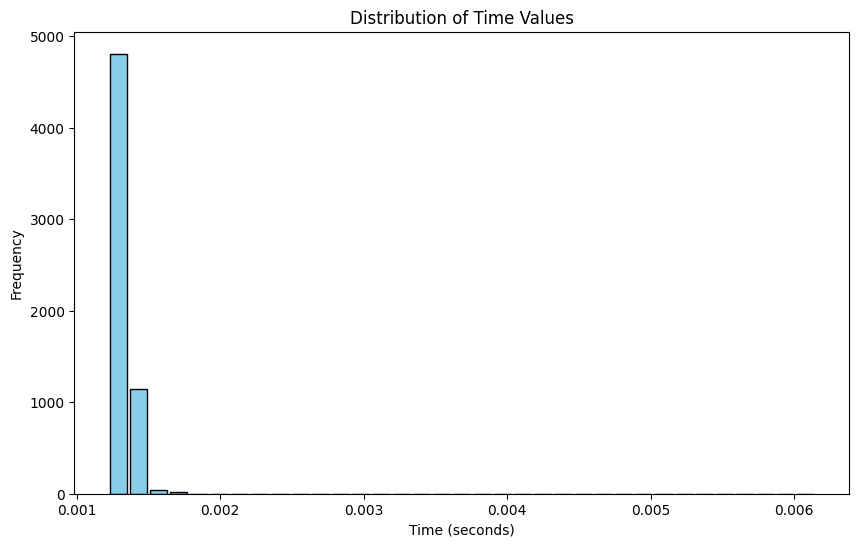

In [27]:
import re
import matplotlib.pyplot as plt

def plot_time_distribution(filename):
    # Regex pattern to match the time values
    time_pattern = re.compile(r'^Time:\s+(\d+\.\d+)')
    times = []
    
    # Read the file and extract time values
    with open(filename, 'r') as file:
        for line in file:
            # Check for a line with the time value
            match = time_pattern.match(line)
            if match:
                time_value = float(match.group(1))
                times.append(time_value)
    
    # Plot the histogram with custom range and bar width
    plt.figure(figsize=(10, 6))
    # Set the range for the histogram and increase bin width by setting bins to a specific range with fewer bins
    plt.hist(times, bins=35, range=(min(times), max(times)), color='skyblue', edgecolor='black', rwidth=0.85)
    plt.title("Distribution of Time Values")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency")
    plt.show()

# Example usage
filename = 'queries.txt'  # Replace with the path to your file
plot_time_distribution(faiss_txt)


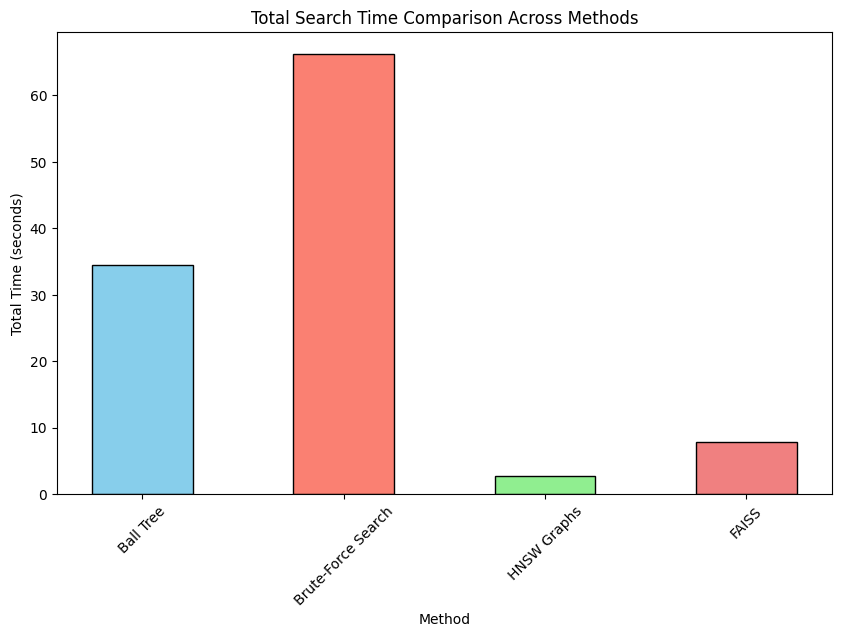

In [22]:
import re
import matplotlib.pyplot as plt

def plot_total_time_comparison(filenames):
    methods = []
    times = []
    
    # Regex patterns to extract method title and total time
    method_pattern = re.compile(r'^Method:\s+(.+)')
    total_time_pattern = re.compile(r'Total search time for .*: (\d+\.\d+) seconds')
    
    # Loop through each file to extract the method title and total time
    for filename in filenames:
        with open(filename, 'r') as file:
            method = None
            total_time = None
            for line in file:
                # Search for the method title at the top of the file
                method_match = method_pattern.match(line)
                if method_match and method is None:
                    method = method_match.group(1)
                
                # Search for the total time at the bottom of the file
                total_time_match = total_time_pattern.search(line)
                if total_time_match:
                    total_time = float(total_time_match.group(1))
                    
            if method and total_time:
                methods.append(method)
                times.append(total_time)
    
    # Plotting the multi-bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(methods, times, width=0.5, color=['skyblue', 'salmon', 'lightgreen', 'lightcoral'], edgecolor='black')
    plt.title("Total Search Time Comparison Across Methods")
    plt.xlabel("Method")
    plt.ylabel("Total Time (seconds)")
    plt.xticks(rotation=45)
    plt.show()

# Example usage
filenames = [bts_txt, bfs_txt, graph_txt, faiss_txt]  # Replace with paths to your files
plot_total_time_comparison(filenames)


In [10]:
int((max(times) - min(times)) / 0.05)

NameError: name 'times' is not defined

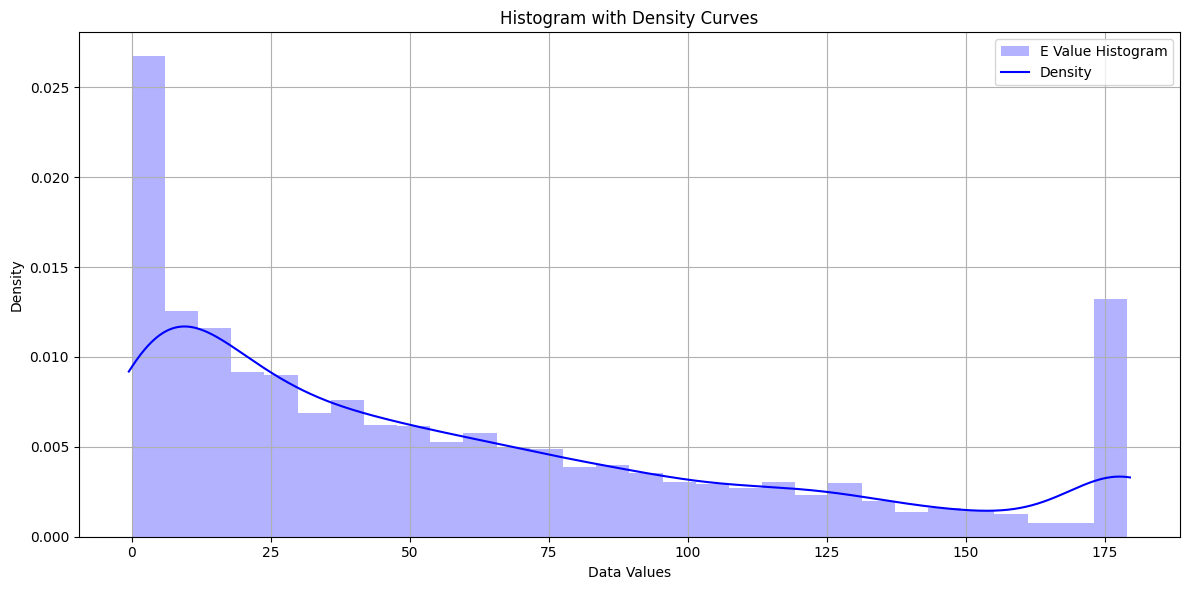

In [16]:
plot_density_curves(1, e_val + [max(e_val)]*325)
